In [1]:
import pandas as pd
from datetime import datetime
from zoe import find_latest, read_pickle, latest_map_data, find_previous, plot_study, plot_study_evolution

In [2]:
path, dt = find_latest('zoe_uk_active_cases_*.pickle', date_index=-2)
curr_date = pd.to_datetime(dt)
uk_active_cases = read_pickle(path)
print(path)
display(uk_active_cases)

/Users/chris/coronavirus/data/zoe_uk_active_cases_2021-08-24_2021-08-24-18-02.pickle


,cartodb_id,the_geom,the_geom_webmercator,corrected_covid_positive
date,,,,
2020-06-12,97743,None,None,61358.469481
2020-06-13,97744,None,None,58190.236840
2020-06-14,97745,None,None,55088.794473
2020-06-15,97746,None,None,52326.446653
2020-06-16,97747,None,None,49852.821225
...,...,...,...,...
2021-08-20,98177,None,None,630512.009660
2021-08-21,98178,None,None,634581.900368
2021-08-22,98179,None,None,641069.792838


In [3]:
prev_date, prev_uk_active_cases = find_previous(curr_date)

/Users/chris/coronavirus/data/zoe_uk_active_cases_2021-08-23_2021-08-23-18-02.pickle


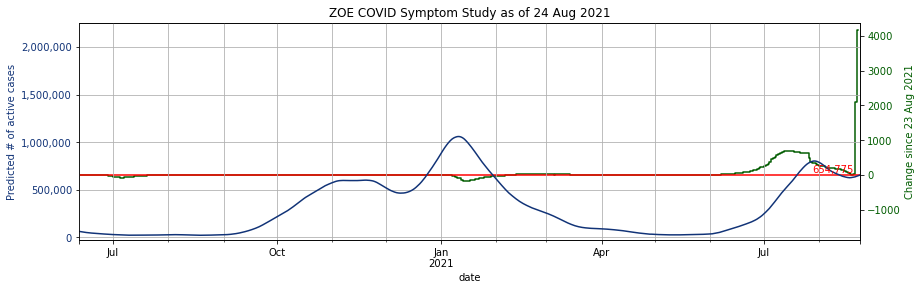

In [4]:
plot_study(curr_date, prev_date, uk_active_cases, prev_uk_active_cases)

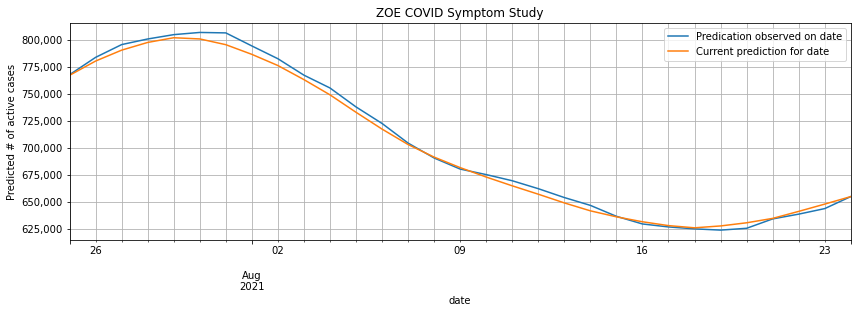

In [5]:
plot_study_evolution(curr_date, days=30)

In [6]:
for_date, prevalence_map = latest_map_data()
f'{for_date:%a %d %b %Y}'

'Tue 24 Aug 2021'

In [7]:
prevalence_map[['lad16nm', 'lad16cd', 'percentage']].sort_values('percentage', ascending=False)[:10]

,lad16nm,lad16cd,percentage
15,"Kingston upon Hull, City of",E06000010,2.844650
73,Isle of Wight,E06000046,2.800737
18,North Lincolnshire,E06000013,2.681325
63,Eden,E07000030,2.644942
195,Ryedale,E07000167,2.563671
277,St. Helens,E08000013,2.551284
281,Newcastle upon Tyne,E08000021,2.378358
146,Watford,E07000103,2.262826
141,North West Leicestershire,E07000134,2.255521
27,Peterborough,E06000031,2.227399
